In [11]:
# BLOCK 1: IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [12]:
# BLOCK 2: LOAD DATA
file_path = "/content/drive/MyDrive/ScoreSight_Dataset.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print(df.describe())


                   Name  Jersey Number     Club    Position Nationality   Age  \
0            Bernd Leno            1.0  Arsenal  Goalkeeper     Germany  28.0   
1            Matt Macey           33.0  Arsenal  Goalkeeper     England  26.0   
2  Rúnar Alex Rúnarsson           13.0  Arsenal  Goalkeeper     Iceland  25.0   
3       Héctor Bellerín            2.0  Arsenal    Defender       Spain  25.0   
4        Kieran Tierney            3.0  Arsenal    Defender    Scotland  23.0   

   Appearances  Wins  Losses  Goals  ...  Punches  High Claims  Catches  \
0           64    28      16      0  ...     34.0         26.0     17.0   
1            0     0       0      0  ...      0.0          0.0      0.0   
2            0     0       0      0  ...      0.0          0.0      0.0   
3          160    90      37      7  ...      NaN          NaN      NaN   
4           16     7       5      1  ...      NaN          NaN      NaN   

   Sweeper clearances  Throw outs  Goal Kicks  Yellow cards  R

In [13]:
# BLOCK 3: DATA CLEANING

df_sorted = df.sort_values(by='Goals', ascending=False).copy()

percent_cols = [col for col in df_sorted.columns
                if df_sorted[col].dtype == object and df_sorted[col].str.contains('%', na=False).any()]

for col in percent_cols:
    df_sorted[col] = df_sorted[col].str.rstrip('%')
    df_sorted[col] = pd.to_numeric(df_sorted[col], errors='coerce')
    df_sorted[col] = df_sorted[col].fillna(df_sorted[col].median())

numeric_cols = df_sorted.select_dtypes(include=[np.number]).columns
df_sorted[numeric_cols] = df_sorted[numeric_cols].fillna(df_sorted[numeric_cols].median())

position_encoder = LabelEncoder()
df_sorted['Position_encoded'] = position_encoder.fit_transform(df_sorted['Position'])

df_sorted = pd.get_dummies(df_sorted, columns=['Club'], prefix='Club', drop_first=False)

if 'Home/Away' in df_sorted.columns:
    df_sorted['Home_Away_encoded'] = df_sorted['Home/Away'].map({'Home': 1, 'Away': 0})
else:
    df_sorted['Home_Away_encoded'] = 1

df_sorted.to_csv("sorted_cleaned_epl_player_data.csv", index=False)

print("Data cleaning completed, columns now include:", df_sorted.columns.tolist())


Data cleaning completed, columns now include: ['Name', 'Jersey Number', 'Position', 'Nationality', 'Age', 'Appearances', 'Wins', 'Losses', 'Goals', 'Goals per match', 'Headed goals', 'Goals with right foot', 'Goals with left foot', 'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target', 'Shooting accuracy %', 'Hit woodwork', 'Big chances missed', 'Clean sheets', 'Goals conceded', 'Tackles', 'Tackle success %', 'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances', 'Headed Clearance', 'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost', 'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists', 'Passes', 'Passes per match', 'Big chances created', 'Crosses', 'Cross accuracy %', 'Through balls', 'Accurate long balls', 'Saves', 'Penalties saved', 'Punches', 'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs', 'Goal Kicks', 'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Position_encoded

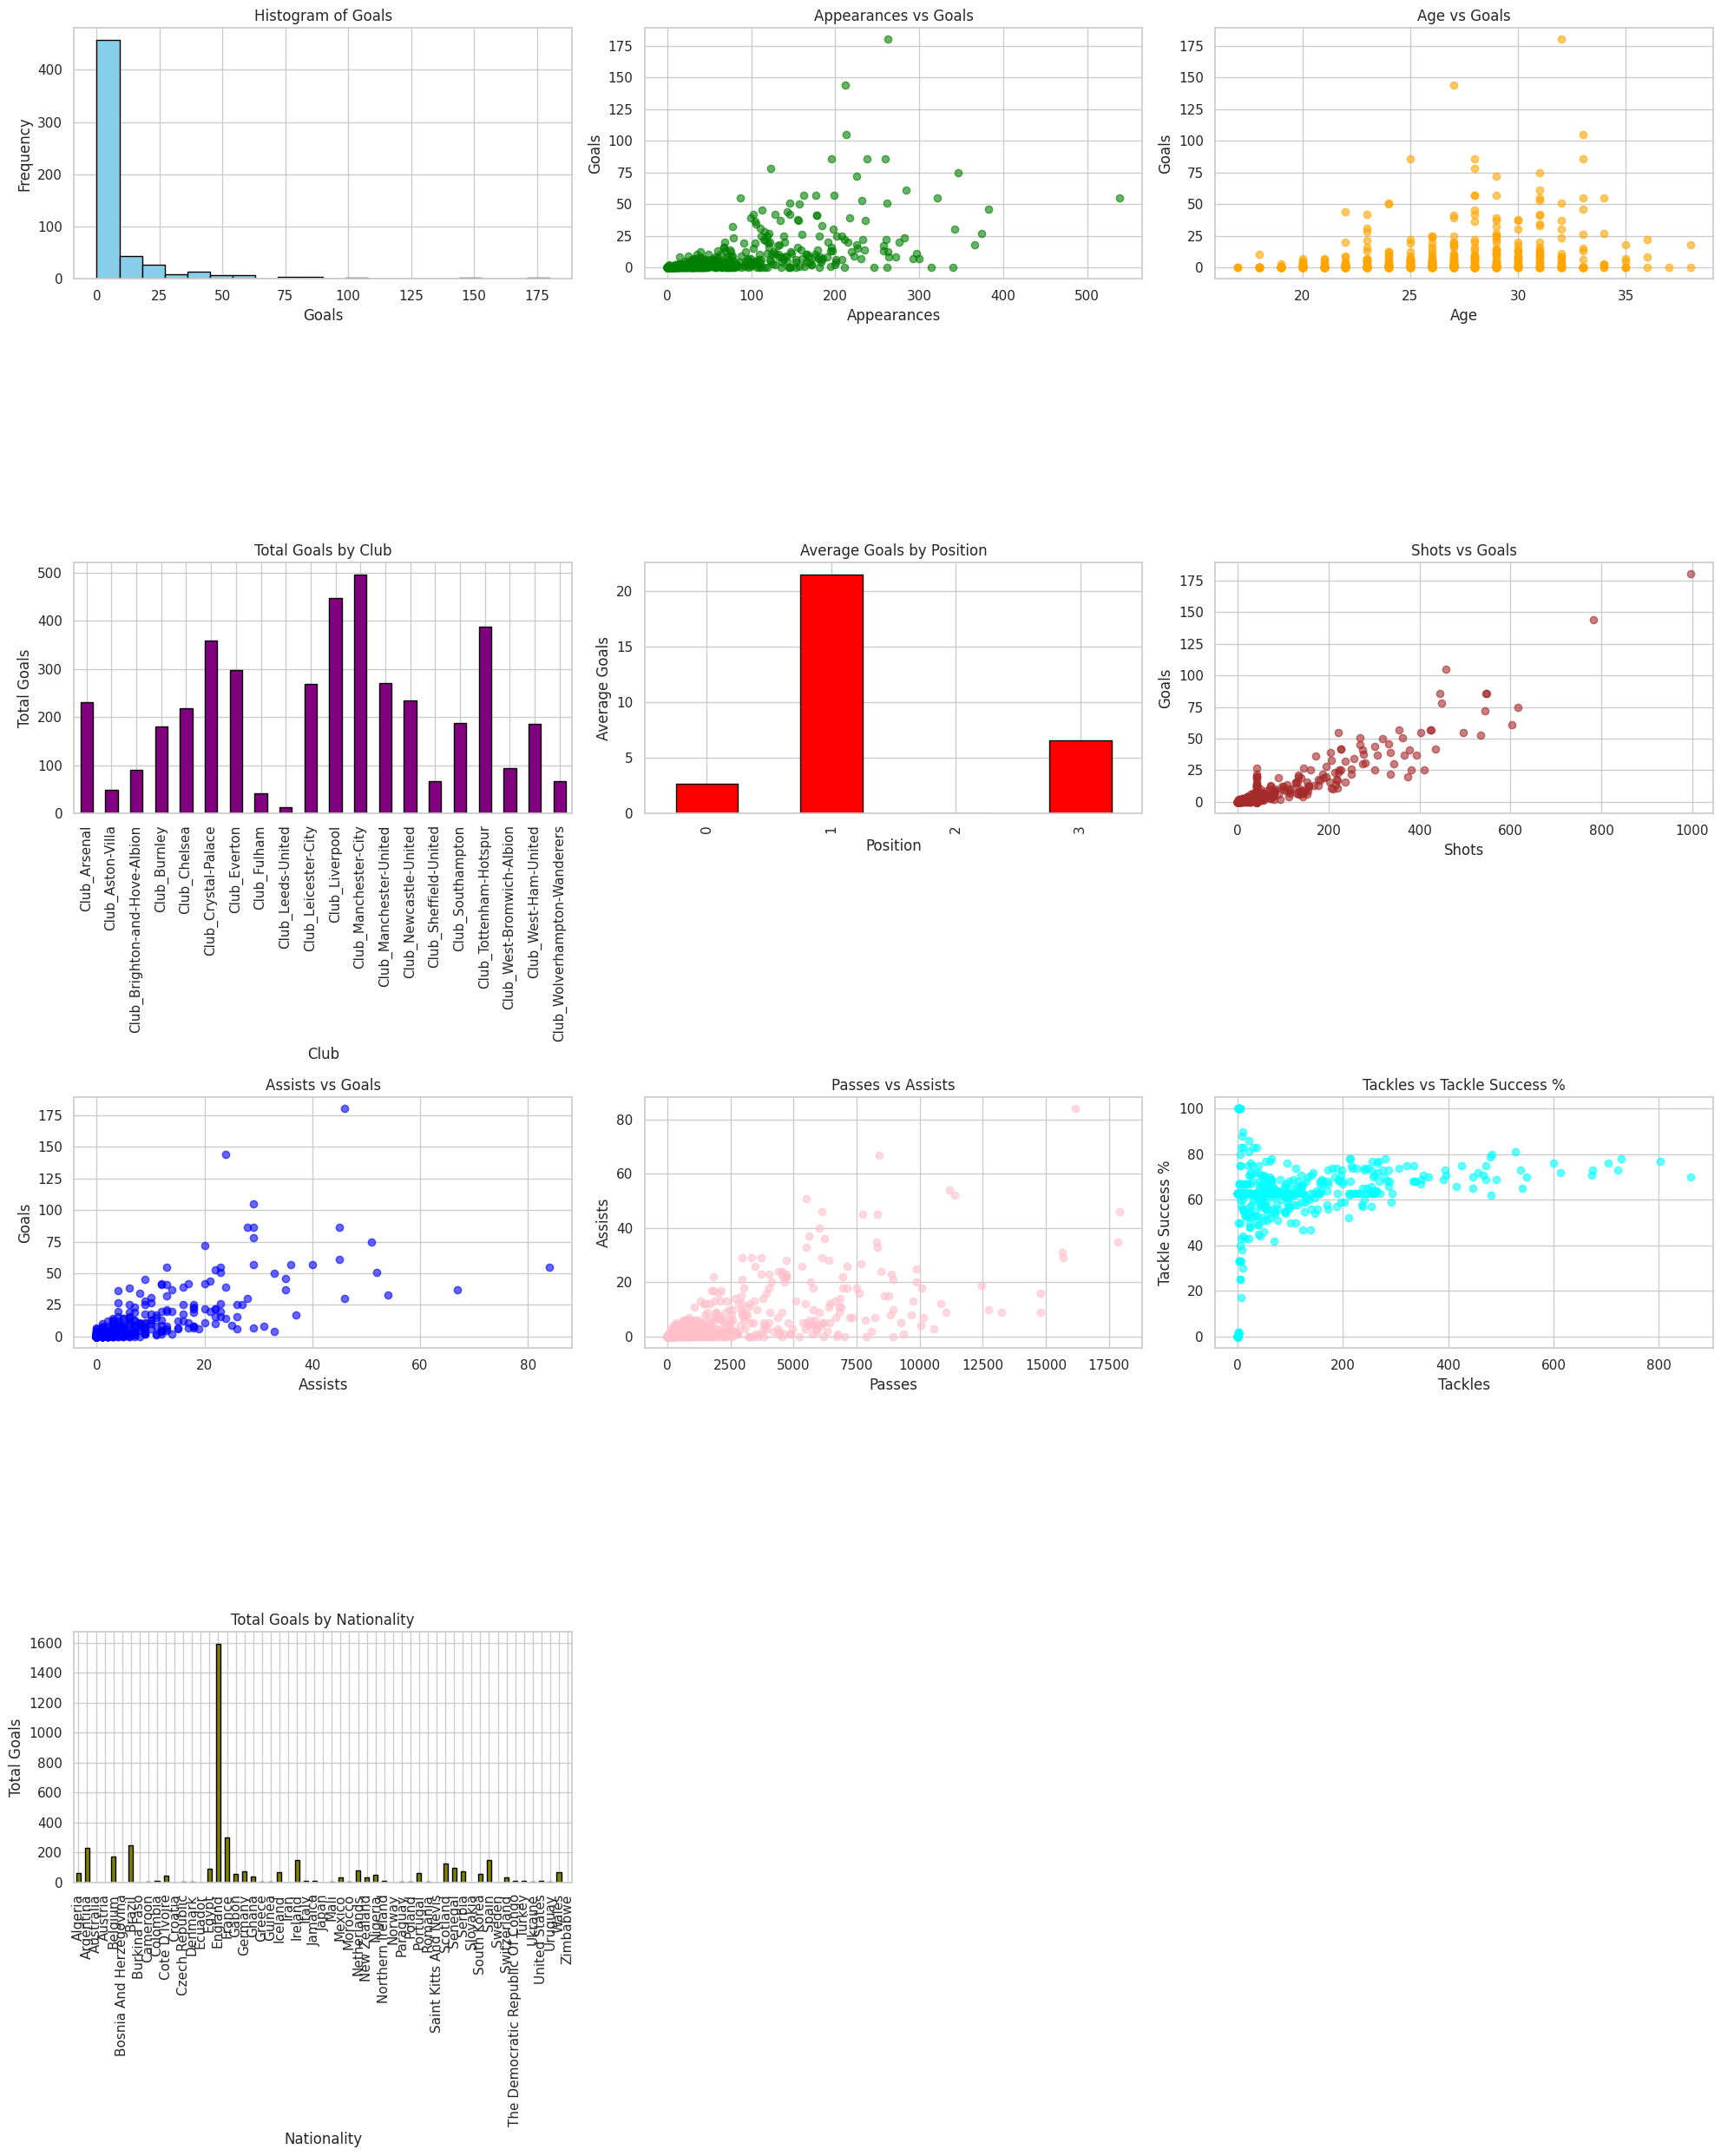

In [14]:
# BLOCK 4: EXPLORATORY DATA ANALYSIS
plt.figure(figsize=(20, 25))

# Histogram: Goals
plt.subplot(4, 3, 1)
plt.hist(df_sorted['Goals'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.title('Histogram of Goals')

# Scatter: Appearances vs Goals
plt.subplot(4, 3, 2)
plt.scatter(df_sorted['Appearances'], df_sorted['Goals'], color='green', alpha=0.6)
plt.xlabel('Appearances')
plt.ylabel('Goals')
plt.title('Appearances vs Goals')

# Scatter: Age vs Goals
plt.subplot(4, 3, 3)
plt.scatter(df_sorted['Age'], df_sorted['Goals'], color='orange', alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Goals')
plt.title('Age vs Goals')

# Bar: Total Goals by Club
plt.subplot(4, 3, 4)
club_cols = [c for c in df_sorted.columns if c.startswith('Club_')]
club_goals = df_sorted[club_cols].multiply(df_sorted['Goals'], axis=0).sum()
club_goals.plot(kind='bar', color='purple', edgecolor='black')
plt.xlabel('Club')
plt.ylabel('Total Goals')
plt.title('Total Goals by Club')

# Bar: Average Goals by Position
plt.subplot(4, 3, 5)
position_goals = df_sorted.groupby('Position_encoded')['Goals'].mean()
position_goals.plot(kind='bar', color='red', edgecolor='black')
plt.xlabel('Position')
plt.ylabel('Average Goals')
plt.title('Average Goals by Position')

# Scatter: Shots vs Goals
plt.subplot(4, 3, 6)
plt.scatter(df_sorted['Shots'], df_sorted['Goals'], color='brown', alpha=0.6)
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.title('Shots vs Goals')

# Scatter: Assists vs Goals
plt.subplot(4, 3, 7)
plt.scatter(df_sorted['Assists'], df_sorted['Goals'], color='blue', alpha=0.6)
plt.xlabel('Assists')
plt.ylabel('Goals')
plt.title('Assists vs Goals')

# Scatter: Passes vs Assists
plt.subplot(4, 3, 8)
plt.scatter(df_sorted['Passes'], df_sorted['Assists'], color='pink', alpha=0.6)
plt.xlabel('Passes')
plt.ylabel('Assists')
plt.title('Passes vs Assists')

# Scatter: Tackles vs Tackle success %
plt.subplot(4, 3, 9)
plt.scatter(df_sorted['Tackles'], df_sorted['Tackle success %'], color='cyan', alpha=0.6)
plt.xlabel('Tackles')
plt.ylabel('Tackle Success %')
plt.title('Tackles vs Tackle Success %')

# Bar: Total Goals by Nationality
if 'Nationality' in df_sorted.columns:
    plt.subplot(4, 3, 10)
    nat_goals = df_sorted.groupby('Nationality')['Goals'].sum()
    nat_goals.plot(kind='bar', color='olive', edgecolor='black')
    plt.xlabel('Nationality')
    plt.ylabel('Total Goals')
    plt.title('Total Goals by Nationality')

plt.tight_layout()
plt.show()


Raw values (first 10 rows):
     Goals  Appearances  Passes
344    180          263    6134
489    144          212    4408
281    105          213    2961
342     86          260    8317
313     86          196    6136
140     86          238    4718
314     78          123    3357
198     75          346    5491
169     72          225    5666
185     61          284    7752


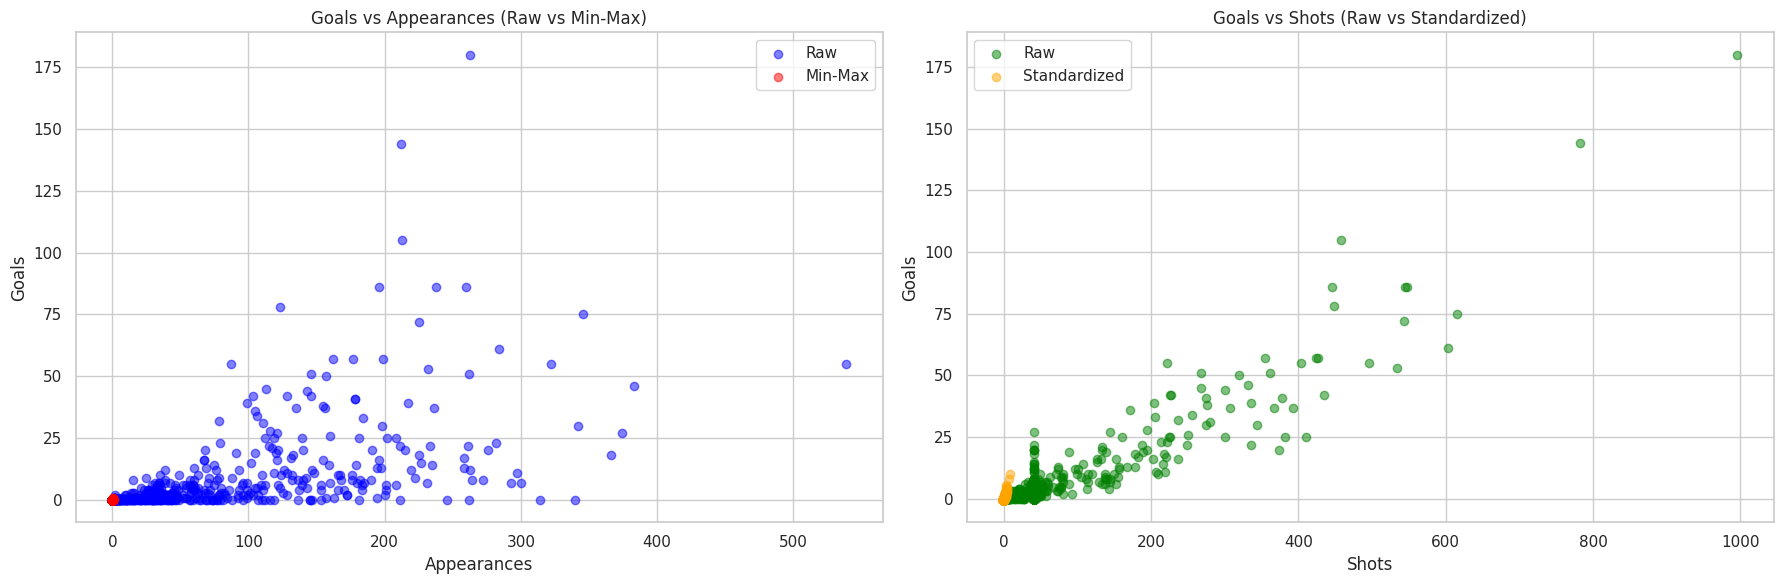

In [15]:
# BLOCK 5: FEATURE SCALING
print("Raw values (first 10 rows):")
print(df_sorted[['Goals', 'Appearances', 'Passes']].head(10))

minmax_cols = ['Goals', 'Appearances', 'Passes', 'Assists']
minmax_scaler = MinMaxScaler()
df_minmax = df_sorted.copy()
df_minmax[minmax_cols] = minmax_scaler.fit_transform(df_minmax[minmax_cols])

std_cols = ['Goals', 'Shots', 'Passes']
std_scaler = StandardScaler()
df_std = df_sorted.copy()
df_std[std_cols] = std_scaler.fit_transform(df_std[std_cols])

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_sorted['Appearances'], df_sorted['Goals'], color='blue', alpha=0.5, label='Raw')
plt.scatter(df_minmax['Appearances'], df_minmax['Goals'], color='red', alpha=0.5, label='Min-Max')
plt.xlabel('Appearances')
plt.ylabel('Goals')
plt.title('Goals vs Appearances (Raw vs Min-Max)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_sorted['Shots'], df_sorted['Goals'], color='green', alpha=0.5, label='Raw')
plt.scatter(df_std['Shots'], df_std['Goals'], color='orange', alpha=0.5, label='Standardized')
plt.xlabel('Shots')
plt.ylabel('Goals')
plt.title('Goals vs Shots (Raw vs Standardized)')
plt.legend()
plt.tight_layout()
plt.show()


Regression CV Results:
LinearRegression {'MAE': np.float64(4.13067466462566), 'RMSE': np.float64(6.518200367182095), 'R2': np.float64(0.8257923615806249)}
RandomForest {'MAE': np.float64(3.0701933827042525), 'RMSE': np.float64(6.683474440350213), 'R2': np.float64(0.8239629065888753)}
GradientBoosting {'MAE': np.float64(3.203073940791966), 'RMSE': np.float64(7.156746135478947), 'R2': np.float64(0.8008259125707579)}

Classification CV Results:
LogisticRegression {'Accuracy': np.float64(0.9539655996177736), 'Precision': np.float64(0.9834803112972127), 'Recall': np.float64(0.9585996955859969), 'F1': np.float64(0.970612335951809)}
GradientBoosting {'Accuracy': np.float64(0.9473483038700431), 'Precision': np.float64(0.9670018030764702), 'Recall': np.float64(0.9668949771689498), 'F1': np.float64(0.9668937769835265)}
XGBoost {'Accuracy': np.float64(0.9495699952221692), 'Precision': np.float64(0.9670007746507843), 'Recall': np.float64(0.9696347031963469), 'F1': np.float64(0.9682904288579435)}
B

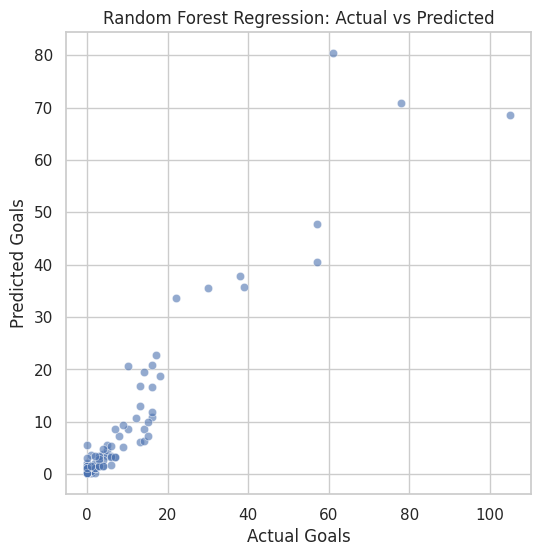

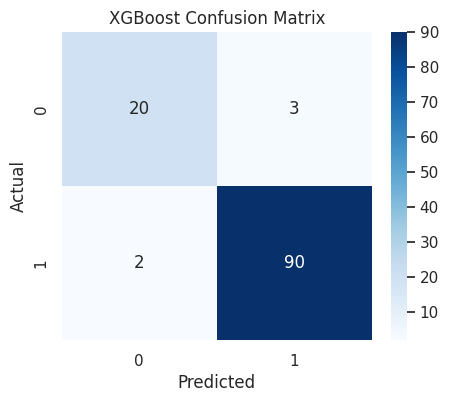

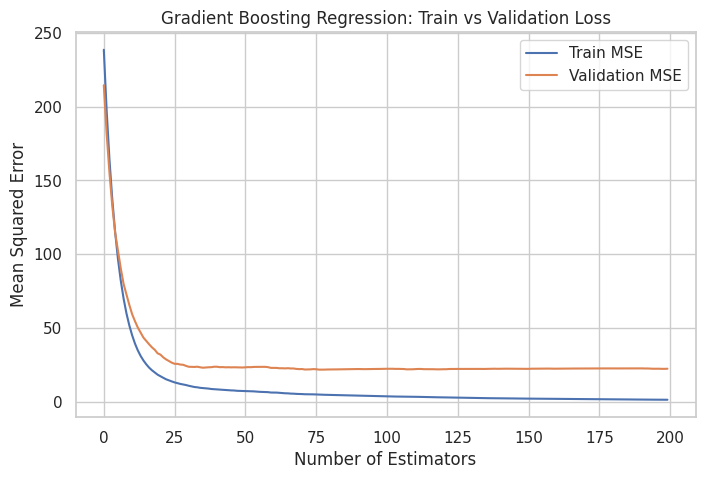

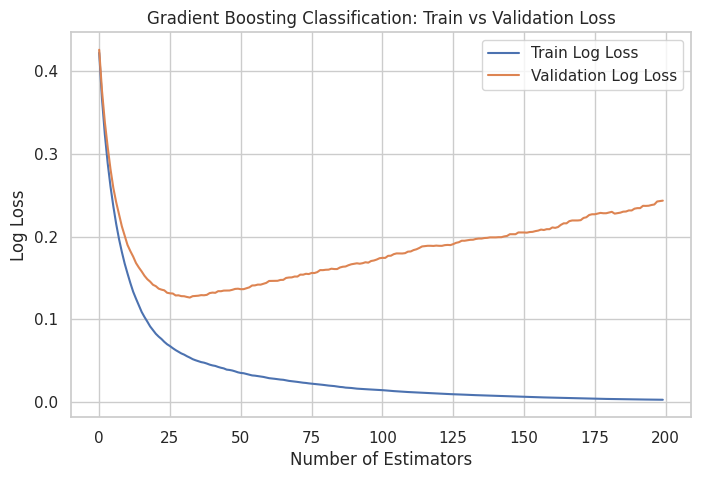

In [16]:
# BLOCK 6: ML MODELING & EVALUATION
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. PREPARE FEATURES & TARGETS

reg_features = ['Appearances', 'Shots', 'Passes', 'Assists', 'Age']
X_reg = df_sorted[reg_features].copy()
y_reg = df_sorted['Goals'].copy()

clf_features = ['Home_Away_encoded', 'Appearances', 'Shots', 'Passes', 'Assists', 'Age']
X_clf = df_sorted[clf_features].copy()
y_clf = df_sorted['Wins'].apply(lambda x: 1 if x > 0 else 0)

num_imputer = SimpleImputer(strategy='median')
X_reg = pd.DataFrame(num_imputer.fit_transform(X_reg), columns=reg_features)
X_clf = pd.DataFrame(num_imputer.fit_transform(X_clf), columns=clf_features)

# 2. TRAIN / TEST SPLIT
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# 3. CROSS-VALIDATION SETUP
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. DEFINE MODELS
models_reg = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

models_clf = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 5. CROSS-VALIDATION EVALUATION
reg_results = {}
for name, model in models_reg.items():
    maes, rmses, r2s = [], [], []
    for train_idx, val_idx in kf.split(X_reg_train):
        X_train_cv, X_val_cv = X_reg_train.iloc[train_idx], X_reg_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_reg_train.iloc[train_idx], y_reg_train.iloc[val_idx]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        maes.append(mean_absolute_error(y_val_cv, y_pred_cv))
        rmses.append(np.sqrt(mean_squared_error(y_val_cv, y_pred_cv)))
        r2s.append(r2_score(y_val_cv, y_pred_cv))
    reg_results[name] = {'MAE': np.mean(maes), 'RMSE': np.mean(rmses), 'R2': np.mean(r2s)}

clf_results = {}
for name, model in models_clf.items():
    accs, precs, recs, f1s = [], [], [], []
    for train_idx, val_idx in skf.split(X_clf_train, y_clf_train):
        X_train_cv, X_val_cv = X_clf_train.iloc[train_idx], X_clf_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_clf_train.iloc[train_idx], y_clf_train.iloc[val_idx]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        accs.append(accuracy_score(y_val_cv, y_pred_cv))
        precs.append(precision_score(y_val_cv, y_pred_cv))
        recs.append(recall_score(y_val_cv, y_pred_cv))
        f1s.append(f1_score(y_val_cv, y_pred_cv))
    clf_results[name] = {'Accuracy': np.mean(accs), 'Precision': np.mean(precs),
                         'Recall': np.mean(recs), 'F1': np.mean(f1s)}

print("Regression CV Results:")
for m, metrics in reg_results.items():
    print(m, metrics)

print("\nClassification CV Results:")
for m, metrics in clf_results.items():
    print(m, metrics)

# 6. HYPERPARAMETER TUNING
reg_param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 5, 8], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), reg_param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_rf.fit(X_reg_train, y_reg_train)
best_reg = grid_rf.best_estimator_
print("Best Random Forest Regressor params:", grid_rf.best_params_)

clf_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, 5]}
rand_xgb = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                              clf_param_grid, n_iter=4, cv=skf, scoring='accuracy', random_state=42)
rand_xgb.fit(X_clf_train, y_clf_train)
best_clf = rand_xgb.best_estimator_
print("Best XGBoost Classifier params:", rand_xgb.best_params_)

# 7. FINAL TRAINING & PREDICTIONS
best_reg.fit(X_reg_train, y_reg_train)
y_reg_pred = best_reg.predict(X_reg_test)

best_clf.fit(X_clf_train, y_clf_train)
y_clf_pred = best_clf.predict(X_clf_test)

# 8. VISUALIZATIONS
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_reg_test, y=y_reg_pred, alpha=0.6)
plt.xlabel("Actual Goals")
plt.ylabel("Predicted Goals")
plt.title("Random Forest Regression: Actual vs Predicted")
plt.show()

cm = confusion_matrix(y_clf_test, y_clf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb_reg.fit(X_reg_train, y_reg_train)
train_loss = [mean_squared_error(y_reg_train, y_pred) for y_pred in gb_reg.staged_predict(X_reg_train)]
val_loss = [mean_squared_error(y_reg_test, y_pred) for y_pred in gb_reg.staged_predict(X_reg_test)]
plt.figure(figsize=(8,5))
plt.plot(np.arange(gb_reg.n_estimators_), train_loss, label='Train MSE')
plt.plot(np.arange(gb_reg.n_estimators_), val_loss, label='Validation MSE')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error")
plt.title("Gradient Boosting Regression: Train vs Validation Loss")
plt.legend()
plt.show()

gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb_clf.fit(X_clf_train, y_clf_train)
train_loss_clf = [-np.mean(y_clf_train*np.log(p[:,1]) + (1-y_clf_train)*np.log(1-p[:,1]))
                  for p in gb_clf.staged_predict_proba(X_clf_train)]
val_loss_clf = [-np.mean(y_clf_test*np.log(p[:,1]) + (1-y_clf_test)*np.log(1-p[:,1]))
                for p in gb_clf.staged_predict_proba(X_clf_test)]
plt.figure(figsize=(8,5))
plt.plot(np.arange(gb_clf.n_estimators_), train_loss_clf, label='Train Log Loss')
plt.plot(np.arange(gb_clf.n_estimators_), val_loss_clf, label='Validation Log Loss')
plt.xlabel("Number of Estimators")
plt.ylabel("Log Loss")
plt.title("Gradient Boosting Classification: Train vs Validation Loss")
plt.legend()
plt.show()


Regression Test Inference (Goals):
Actual: 16, Predicted: 11.87
Actual: 2, Predicted: 3.40
Actual: 0, Predicted: 1.25
Actual: 1, Predicted: 1.57
Actual: 18, Predicted: 18.69

Classification Test Inference (Win/No Win):
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 1, Predicted: 0


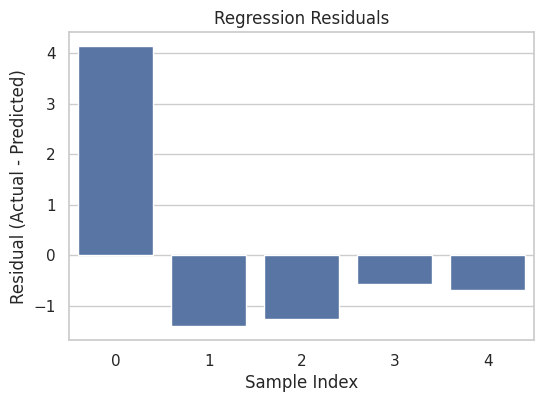

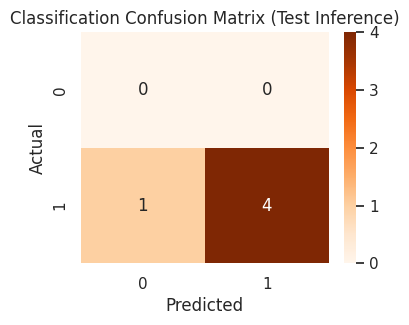

In [17]:
# BLOCK 8: SAVE/LOAD MODELS AND TEST INFERENCE

import joblib

joblib.dump(best_reg, "best_regressor.pkl")
joblib.dump(best_clf, "best_classifier.pkl")
joblib.dump(position_encoder, "position_encoder.pkl")  # if needed for future encoding

reg_model = joblib.load("best_regressor.pkl")
clf_model = joblib.load("best_classifier.pkl")

X_reg_new = X_reg_test.tail(5)
y_reg_actual = y_reg_test.tail(5)
y_reg_pred_new = reg_model.predict(X_reg_new)

X_clf_new = X_clf_test.tail(5)
y_clf_actual = y_clf_test.tail(5)
y_clf_pred_new = clf_model.predict(X_clf_new)

print("Regression Test Inference (Goals):")
for actual, pred in zip(y_reg_actual, y_reg_pred_new):
    print(f"Actual: {actual}, Predicted: {pred:.2f}")

print("\nClassification Test Inference (Win/No Win):")
for actual, pred in zip(y_clf_actual, y_clf_pred_new):
    print(f"Actual: {actual}, Predicted: {pred}")

residuals = y_reg_actual - y_reg_pred_new
plt.figure(figsize=(6,4))
sns.barplot(x=np.arange(len(residuals)), y=residuals)
plt.xlabel("Sample Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Regression Residuals")
plt.show()

cm_new = confusion_matrix(y_clf_actual, y_clf_pred_new)
plt.figure(figsize=(4,3))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Classification Confusion Matrix (Test Inference)")
plt.show()
